# Nettverksanalyser

In [69]:
# load packages
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import arcpy
import os
import scipy as scipy
import pandas as pd
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances


pd.set_option('display.max_columns', None)
np.set_printoptions(precision=20)

def distanceMatrix(xy):
    return(squareform(pdist(xy)))


# Function to calculate distances, both Euclidian and "realised"/"Experienced" distances, where the latter is a probability output
def calculate_distance_matrix(input_feature_class, Alpha = 1/1000, ExportLines = False):
    """
    This function calculates a distance matrix for all points in the input feature class using NumPy arrays.
    
    :param input_feature_class: Path to the input feature class containing point geometries.
    :return: A NumPy array representing the distance matrix.
    """
    # Retrieve the spatial reference of the input feature class.
    sr = arcpy.Describe(input_feature_class).spatialReference

    # Get the number of points in the input feature class.
    point_count = int(arcpy.GetCount_management(input_feature_class).getOutput(0))

    # Initialize a NumPy array to store the distance matrix with zeros.
    distance_matrix = np.zeros((point_count, point_count))
    # Initialize a NumPy array to store the dispersal probabilities.
    distance_matrix_exp = np.zeros((point_count, point_count))

    # Create a list to store geometries and their IDs.
    geometries = []    
    
    # Here we have chunk where we create a feature class where we can store the lines going btw all the features
    # Define the spatial reference
    spatial_ref = arcpy.Describe(input_feature_class).spatialReference
    
    # Use a search cursor to iterate through the features and store geometries.
    with arcpy.da.SearchCursor(input_feature_class, ["OID@", "SHAPE@"], spatial_reference=sr) as cursor:
        for row in cursor:
            oid, geom = row
            geometries.append((oid, geom))

    # Calculate distances and fill the NumPy array.
    for i, (oid_from, geom_from) in enumerate(geometries):
        #print(i)
        for j, (oid_to, geom_to) in enumerate(geometries):
            if oid_from != oid_to:  # Ensure that we don't calculate the distance to the same feature.
                distance = geom_from.distanceTo(geom_to)  # Calculate the distance to another feature.
                distance_matrix[i, j] = distance  # Store the calculated distance in the array.
                distance_matrix_exp[i, j] = np.exp(-distance*Alpha)  # Store the calculated distance in the array.
                #if ExportLines is True
                    # Create a new feature class
                    #new_feature_class = 'Paths'
                    #arcpy.CreateFeatureclass_management(arcpy.env.workspace, new_feature_class, 'POLYLINE', spatial_reference=spatial_ref)
                    #start_point = geom_from.centroid # now we move over to generating lines btw all the geometries
                #    end_point = geom_to.centroid  #  this lines are later used to illustrate sensitities of the connections
                #    line = arcpy.Polyline(arcpy.Array([start_point, end_point]), spatial_ref) # create a line
                #    # TODO: Add OID
                #    # Use an insert cursor to add the new line to the feature class
                #    with arcpy.da.InsertCursor(new_feature_class, ['SHAPE@']) as cursor:
                #        cursor.insertRow([line])

    return distance_matrix, distance_matrix_exp  # Return the complete distance matrix.

def calculate_areas_and_outer_matrix(feature_class):
    """
    Calculate the areas of features in a feature class and the outer product matrix of these areas.
    
    :param feature_class: Path to the input feature class.
    :return: A tuple containing a list of areas and the outer product matrix.
    """
    # Step 1: Extract Areas
    areas = []
    with arcpy.da.SearchCursor(feature_class, ["SHAPE@AREA"]) as cursor:
        for row in cursor:
            areas.append(row[0])  # Append the area of the feature to the list

    # Step 2: Create Outer Matrix
    areas_array = np.array(areas)  # Convert the list of areas to a NumPy array
    outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix

    return areas, outer_matrix

# Main function
def CalcEigenmeasures(LandscapeMatrix, IDs=None):
    # If IDs is not provided, create an enumerated index
    if IDs is None:
        IDs = np.arange(LandscapeMatrix.shape[0])
    
    # Define the function to calculate contribution
    def calculate_contribution(Lambda, Mij):
        num_patches = Mij.shape[0]
        contributions = np.zeros(num_patches)
        
        for ii in range(num_patches):
            # Exclude the ii-th row and column from Mij
            Mij_sub = np.delete(Mij, ii, axis=0)
            Mij_sub = np.delete(Mij_sub, ii, axis=1)
            
            # Calculate the largest eigenvalue of the modified Mij
            eigenvalues = np.linalg.eigvals(Mij_sub)
            largest_eigenvalue = np.max(eigenvalues)
            
            # Calculate the contribution
            contributions[ii] = (Lambda - largest_eigenvalue) / Lambda
        
        return contributions

    eigenvalues, eigenvectors = scipy.linalg.eig(LandscapeMatrix)
    Le = np.argmax(eigenvalues)
    Lambda = np.real(eigenvalues[Le])
    
    # Approximate stable age distribution = right eigenvector
    w0 = np.real(eigenvectors[:, Le])
    w = np.abs(w0)
    # Reproductive value = left eigenvector
    # This equals the right eigenvector of the landscape matrix transposed
    V = np.linalg.inv(eigenvectors).conj()
    v = np.abs(np.real(V[Le, ]))
    
    # Contribution of the patch to lambda
    # When considering small perturbations, loses a small part of the habitats and habitat degradation
    pc = v.T * w  # These are normalized
    # pc_small = pc / np.sum(pc)  # Normalize the contributions

    # 'pc_s' now contains the normalized contribution of each patch to lambda
    # Call the function with your Lambda and Mij data
    contributions = calculate_contribution(Lambda, LandscapeMatrix)

    # Collect all the measures
    EigenMeasures = pd.DataFrame({"ID": IDs,
                                  "PC_small": pc,
                                  "PC_large": contributions,
                                  "REv": w, 
                                  "LEv": v})
    return EigenMeasures

def communities(landscape_matrix):
    # Convert the input matrix to a NumPy array
    M = np.array(landscape_matrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        print(t)
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]


C:\Users\endofs\AppData\Local\Temp\ipykernel_22364\499543442.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pos[:, 0], pos[:, 1], cmap='viridis')


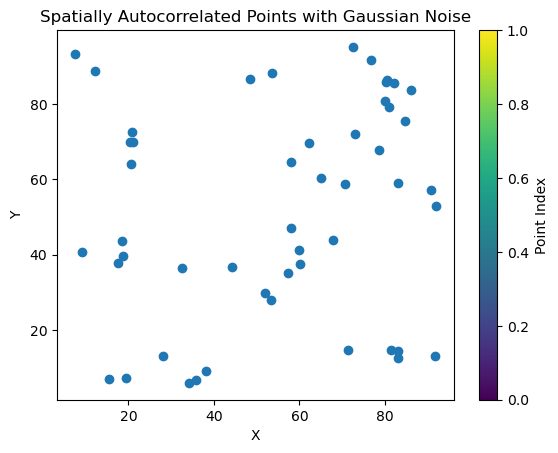

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix

# Function to generate spatially autocorrelated points
def generate_spatially_autocorrelated_points(n_points, autocorrelation_func, size=(100, 100)):
    # Generate initial random points
    points = np.random.rand(n_points, 2) * size
    
    # Calculate distance matrix
    dist_matrix = distance_matrix(points, points)
    
    # Apply autocorrelation function to the distance matrix to get weights
    weights = autocorrelation_func(dist_matrix)
    
    # Adjust points based on weights to introduce spatial autocorrelation
    for i in range(n_points):
        points[i] = np.average(points, axis=0, weights=weights[i])
    
    return points

# Define Gaussian autocorrelation function
def gaussian_autocorrelation(dist_matrix, sigma=10):
    return np.exp(-dist_matrix**2 / (2 * sigma**2))

# Generate points with Gaussian spatial autocorrelation
n_points = 50
pos = generate_spatially_autocorrelated_points(n_points, gaussian_autocorrelation)

# Plot the points
plt.scatter(pos[:, 0], pos[:, 1], cmap='viridis')
plt.colorbar(label='Point Index')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatially Autocorrelated Points with Gaussian Noise')
plt.show()

In [114]:
# If a simple function is wanted
# Generate random positions
#pos = np.vstack([
    #np.column_stack((np.random.uniform(18, 30, 10), np.random.uniform(20, 30, 10))),
    #np.column_stack((np.random.uniform(35, 45, 10), np.random.uniform(50, 60, 10))),
    #np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(170, 190, 10))),
    #np.column_stack((np.random.uniform(170, 190, 10), np.random.uniform(20, 40, 10))),
    #np.column_stack((np.random.uniform(120, 140, 10), np.random.uniform(120, 140, 10)))
#])

# Plot the positions
#plt.scatter(pos[:, 0], pos[:, 1])
#plt.show()

In [118]:
# Calculate the distance matrix
M = squareform(pdist(pos))

# Apply the exponential transformation
M0 = np.exp(-M * (1/30))

# Set the diagonal to zero
np.fill_diagonal(M0, 0)

In [119]:
results = communities(M0)
print(results.shape[1])
print(results)

Run loop
0
1
2
3
5
[['0' 2 3 5 8]
 ['1' 1 1 1 1]
 ['2' 1 2 2 3]
 ['3' 2 4 7 12]
 ['4' 2 3 5 9]
 ['5' 1 2 2 2]
 ['6' 2 3 4 7]
 ['7' 2 3 4 7]
 ['8' 2 4 7 12]
 ['9' 1 1 1 1]
 ['10' 2 3 5 8]
 ['11' 2 4 7 12]
 ['12' 1 1 1 1]
 ['13' 1 1 1 1]
 ['14' 2 3 5 9]
 ['15' 2 4 7 13]
 ['16' 1 2 2 2]
 ['17' 1 2 3 4]
 ['18' 2 4 7 12]
 ['19' 1 1 1 1]
 ['20' 1 1 1 1]
 ['21' 2 4 7 12]
 ['22' 2 4 6 10]
 ['23' 1 2 3 5]
 ['24' 2 4 7 13]
 ['25' 1 2 3 4]
 ['26' 2 3 4 6]
 ['27' 2 3 5 9]
 ['28' 1 1 1 1]
 ['29' 2 3 5 9]
 ['30' 1 2 3 5]
 ['31' 1 1 1 1]
 ['32' 2 4 6 10]
 ['33' 2 4 6 11]
 ['34' 2 3 4 7]
 ['35' 2 4 6 11]
 ['36' 2 4 6 10]
 ['37' 2 4 6 10]
 ['38' 1 2 2 3]
 ['39' 2 3 4 7]
 ['40' 2 4 7 13]
 ['41' 2 3 4 7]
 ['42' 2 4 6 11]
 ['43' 1 1 1 1]
 ['44' 2 4 6 10]
 ['45' 1 1 1 1]
 ['46' 1 1 1 1]
 ['47' 1 2 2 3]
 ['48' 2 4 7 13]
 ['49' 1 2 2 3]]


In [120]:
sizes = np.random.uniform(4, 30, len(M0))
# Step 2: Create Outer Matrix
areas_array = sizes
outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix
dists = distanceMatrix(pos)
realizedDists = np.exp(-dists*.5)
Mij = realizedDists*outer_matrix
# set diagonal to zero
np.fill_diagonal(Mij, 0)
Mij
print(np.arange(Mij.shape[0]))
tmp = CalcEigenmeasures(Mij)
print(tmp)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
    ID      PC_small      PC_large           REv           LEv
0    0  1.916021e-31 -5.085707e-16  5.962463e-16  3.213472e-16
1    1  3.175402e-01  4.583072e-01  5.635071e-01  5.635071e-01
2    2  7.202090e-13  7.137789e-13  8.486513e-07  8.486513e-07
3    3  1.391642e-28  1.398569e-15  1.180143e-14  1.179215e-14
4    4  2.229326e-27 -5.085707e-16  4.722373e-14  4.720775e-14
5    5  7.047433e-18 -8.899987e-16  2.654700e-09  2.654700e-09
6    6  3.223722e-32  8.899987e-16  1.700188e-16  1.896097e-16
7    7  2.325540e-34  1.017141e-15  4.989546e-18  4.660826e-17
8    8  2.722686e-29  7.628560e-16  5.214417e-15  5.221457e-15
9    9  2.964217e-02  3.018078e-02  1.721690e-01  1.721690e-01
10  10  1.488214e-28  3.814280e-16  1.237284e-14  1.202806e-14
11  11  2.370524e-28  0.000000e+00  1.537363e-14  1.541941e-14
12  12  4.524848e-07  4.523

C:\Users\endofs\AppData\Local\Temp\ipykernel_22364\4175658688.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0, 0].scatter(pos[:, 0], pos[:, 1], cmap='viridis')


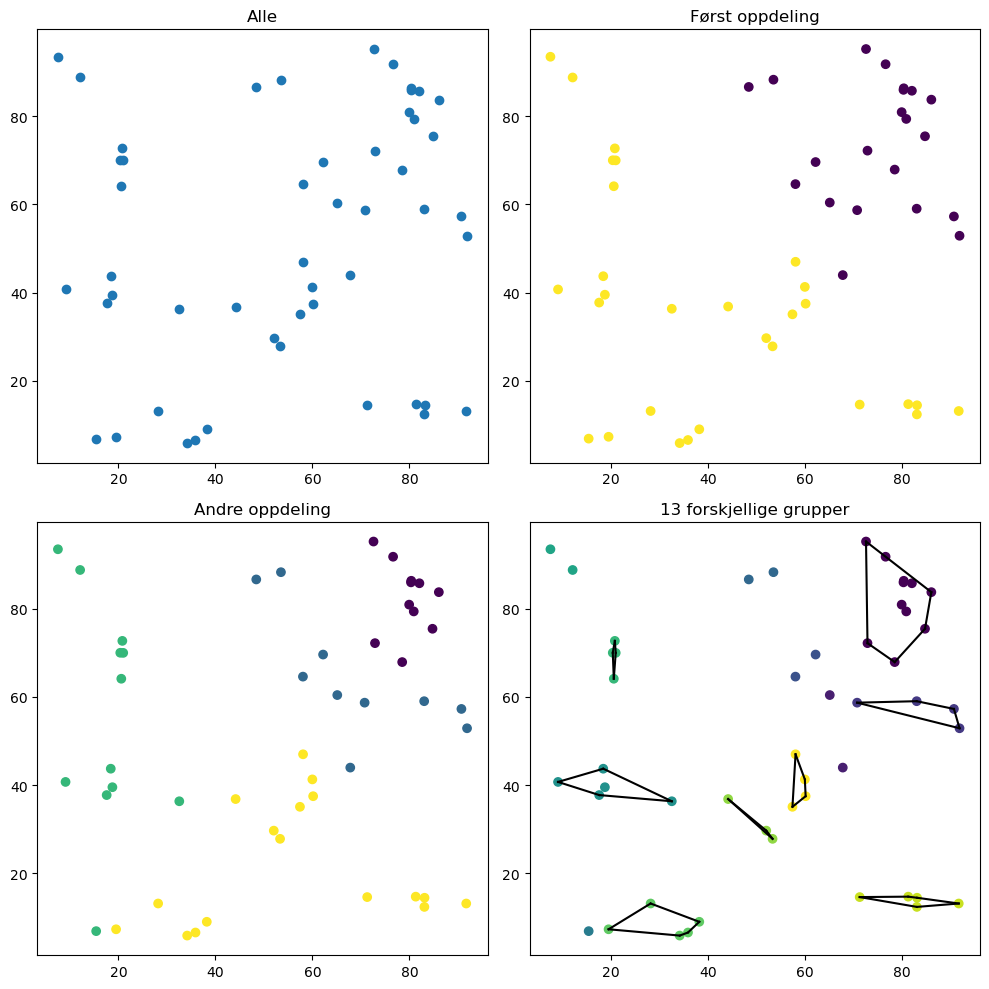

In [123]:
from scipy.spatial import ConvexHull
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot each scatter plot in its respective subplot
axs[0, 0].scatter(pos[:, 0], pos[:, 1], cmap='viridis')
axs[0, 0].set_title('Alle')

axs[0, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,1], cmap='viridis')
axs[0, 1].set_title('Først oppdeling')

axs[1, 0].scatter(pos[:, 0], pos[:, 1], c=results[:,2], cmap='viridis')
axs[1, 0].set_title('Andre oppdeling')

# Get unique groups
unique_groups = np.unique(results[:,int(results.shape[1])-1])

axs[1, 1].scatter(pos[:, 0], pos[:, 1], c=results[:,int(results.shape[1])-1], cmap='viridis')
axs[1, 1].set_title(f"{len(unique_groups)} forskjellige grupper" )


# Add convex hull or polygon around each group
for group in unique_groups:
    group_points = pos[results[:,int(results.shape[1])-1] == group]
    if len(group_points) >= 3:  # ConvexHull requires at least 3 points
        hull = ConvexHull(group_points)
        for simplex in hull.simplices:
            plt.plot(group_points[simplex, 0], group_points[simplex, 1], 'k-')


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Nettverkfunksjonssammensatt

In [11]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import arcpy
import os
import scipy as scipy
import pandas as pd
from scipy.linalg import eig
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import euclidean_distances
import geopandas as gpd
import numpy as np
from scipy.spatial.distance import pdist, squareform
import os


In [ ]:
# Function to calculate distance matrix
def distanceMatrix(xy):
    return squareform(pdist(xy))
# Function to calculate polygon distances
def polygon_distance_matrix(gdf):
    n = len(gdf)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = gdf.geometry.iloc[i].distance(gdf.geometry.iloc[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

# Function to read the feature class based on file extension
def read_feature_class(file_path):
    file_extension = os.path.splitext(file_path)[1].lower()
    if file_extension == '.gpkg':
        gdf = gpd.read_file(file_path, layer=0)
    elif file_extension == '.gdb':
        gdf = gpd.read_file(file_path, driver='FileGDB', layer="GRUK")
       # gdf = gpd.read_file(file_path, driver='FileGDB', layer="0")
    else:
        raise ValueError("Unsupported file format. Please provide a GeoPackage (.gpkg) or File Geodatabase (.gdb).")
    return gdf

def calculate_landscapematrix(file_path, use_centroid=True, decay_factor=0.5):   

    # Read the feature class
    gdf = read_feature_class(file_path)

    if use_centroid:
        # Calculate the centroid coordinates
        gdf['coordinates'] = gdf.geometry.centroid
        xy = np.array(list(zip(gdf.coordinates.x, gdf.coordinates.y)))
        # Ensure xy is a 2-dimensional array
        if xy.ndim != 2 or xy.shape[1] != 2:
            raise ValueError("Coordinates array 'xy' must be a 2-dimensional array with shape (n, 2).")
        # Calculate distance matrix using centroids
        dists = distanceMatrix(xy)
    else:
        # Calculate distance matrix using polygons
        dists = polygon_distance_matrix(gdf)

    # Calculate the areas of the geometries
    sizes = gdf.geometry.area

    # Create Outer Matrix
    areas_array = sizes
    outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix

    # Calculate realized distances with the decay factor
    realizedDists = np.exp(-dists * decay_factor)

    # Calculate Mij
    Mij = realizedDists * outer_matrix

    # Set diagonal to zero
    np.fill_diagonal(Mij, 0)

    # return results
    return Mij

    # Print the result
    print(Mij)    


def CalcEigenmeasures(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=0.5, IDs=None):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # If IDs is not provided, create an enumerated index
    if IDs is None:
        IDs = np.arange(LandscapeMatrix.shape[0])
    
    # Define the function to calculate contribution
    def calculate_contribution(Lambda, Mij):
        num_patches = Mij.shape[0]
        contributions = np.zeros(num_patches)
        
        for ii in range(num_patches):
            # Exclude the ii-th row and column from Mij
            Mij_sub = np.delete(Mij, ii, axis=0)
            Mij_sub = np.delete(Mij_sub, ii, axis=1)
            
            # Calculate the largest eigenvalue of the modified Mij
            eigenvalues = np.linalg.eigvals(Mij_sub)
            largest_eigenvalue = np.max(eigenvalues)
            
            # Calculate the contribution
            contributions[ii] = (Lambda - largest_eigenvalue) / Lambda
        
        return contributions

    eigenvalues, eigenvectors = scipy.linalg.eig(LandscapeMatrix)
    Le = np.argmax(eigenvalues)
    Lambda = np.real(eigenvalues[Le])
    
    # Approximate stable age distribution = right eigenvector
    w0 = np.real(eigenvectors[:, Le])
    w = np.abs(w0)
    # Reproductive value = left eigenvector
    # This equals the right eigenvector of the landscape matrix transposed
    V = np.linalg.inv(eigenvectors).conj()
    v = np.abs(np.real(V[Le, ]))
    
    # Contribution of the patch to lambda
    # When considering small perturbations, loses a small part of the habitats and habitat degradation
    pc = v.T * w  # These are normalized

    # Call the function with your Lambda and Mij data
    contributions = calculate_contribution(Lambda, LandscapeMatrix)

    # Collect all the measures
    EigenMeasures = pd.DataFrame({"ID": IDs,
                                  "PC_small": pc,
                                  "PC_large": contributions,
                                  "REv": w, 
                                  "LEv": v})
    
    return EigenMeasures


def communities(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=0.5):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # Convert the input matrix to a NumPy array
    M = np.array(LandscapeMatrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]



In [31]:

# Example usage
file_path = 'C:/Users/endofs/OneDrive - Miljødirektoratet/Dokumenter/ArcGIS/Projects/MyProject/MyProject.gdb'
a = calculate_landscapematrix(file_path, use_centroid=True, decay_factor=0.5)
print(a)

# Example usage with geometry file path
geometry_path = 'C:/Users/endofs/OneDrive - Miljødirektoratet/Dokumenter/ArcGIS/Projects/MyProject/MyProject.gdb'
eigen_measures_df = CalcEigenmeasures(geometry=geometry_path, use_centroid=True, decay_factor=0.5)
print(eigen_measures_df)

[[0.0000000000000000e+000 0.0000000000000000e+000 7.7886847667833327e-064
  ... 3.1638353704223162e-213 0.0000000000000000e+000
  0.0000000000000000e+000]
 [0.0000000000000000e+000 0.0000000000000000e+000 0.0000000000000000e+000
  ... 0.0000000000000000e+000 0.0000000000000000e+000
  0.0000000000000000e+000]
 [7.7886847667833327e-064 0.0000000000000000e+000 0.0000000000000000e+000
  ... 1.7616233352268417e-206 0.0000000000000000e+000
  0.0000000000000000e+000]
 ...
 [3.1638353704223162e-213 0.0000000000000000e+000 1.7616233352268417e-206
  ... 0.0000000000000000e+000 0.0000000000000000e+000
  0.0000000000000000e+000]
 [0.0000000000000000e+000 0.0000000000000000e+000 0.0000000000000000e+000
  ... 0.0000000000000000e+000 0.0000000000000000e+000
  2.3419898361158665e+005]
 [0.0000000000000000e+000 0.0000000000000000e+000 0.0000000000000000e+000
  ... 0.0000000000000000e+000 2.3419898361158665e+005
  0.0000000000000000e+000]]


C:\Users\endofs\AppData\Local\Temp\ipykernel_28560\477085690.py:100: ComplexWarning: Casting complex values to real discards the imaginary part
  contributions[ii] = (Lambda - largest_eigenvalue) / Lambda


      ID       PC_small      PC_large            REv           LEv
0      0   2.046765e-69 -2.548167e-16   2.384819e-34  8.582478e-36
1      1  1.078294e-124 -8.918586e-16  2.047337e-107  5.266811e-18
2      2  3.342450e-116 -3.822251e-16   4.681676e-97  7.139430e-20
3      3   1.773389e-48  1.274084e-16   7.812429e-25  2.269958e-24
4      4   2.313648e-43 -8.918586e-16   1.078538e-23  2.145171e-20
..   ...            ...           ...            ...           ...
455  455   1.840318e-80  6.370418e-16   1.786901e-62  1.029894e-18
456  456   6.592843e-39 -5.096335e-16   9.451720e-19  6.975284e-21
457  457   6.592843e-39 -5.096335e-16   9.451720e-19  6.975284e-21
458  458   6.245729e-31  3.822251e-16   7.954541e-16  7.851778e-16
459  459   6.314616e-31  3.822251e-16   7.954541e-16  7.938379e-16

[460 rows x 5 columns]


### Legge til nye områder?

In [ ]:


def calculate_landscapematrix(file_path, use_centroid=True, decay_factor=0.5, file_path_add=None):   
    # Read the feature class
    gdf = read_feature_class(file_path)
    
    if use_centroid:
        # Calculate the centroid coordinates
        gdf['coordinates'] = gdf.geometry.centroid
        xy = np.array(list(zip(gdf.coordinates.x, gdf.coordinates.y)))
        # Ensure xy is a 2-dimensional array
        if xy.ndim != 2 or xy.shape[1] != 2:
            raise ValueError("Coordinates array 'xy' must be a 2-dimensional array with shape (n, 2).")
        # Calculate distance matrix using centroids
        dists = distanceMatrix(xy)
    else:
        # Calculate distance matrix using polygons
        dists = polygon_distance_matrix(gdf)

    # Calculate the areas of the geometries
    sizes = gdf.geometry.area

    if file_path_add is not None:
        # Read the additional feature class
        gdf_add = read_feature_class(file_path_add)
        # Initialize list to store Mij matrices
        Mij_list = []
        
        for add_row in gdf_add.itertuples():
            # Calculate distances from all other features to the new feature
            if use_centroid:
                add_coords = add_row.geometry.centroid
                add_dists = np.array([add_coords.distance(pt) for pt in gdf['coordinates']])
            else:
                add_dists = np.array([add_row.geometry.distance(poly) for poly in gdf.geometry])
            
            # Calculate realized distances with the decay factor
            realizedDists_add = np.exp(-add_dists * decay_factor)
            
            # Calculate Mij for the new feature
            new_areas_array = sizes * add_row.geometry.area
            Mij_add = realizedDists_add * new_areas_array

            # Add new Mij to the list
            Mij_list.append(Mij_add)
        
        # Create initial Mij matrix
        areas_array = sizes
        outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix
        realizedDists = np.exp(-dists * decay_factor)
        Mij = realizedDists * outer_matrix
        np.fill_diagonal(Mij, 0)
        
        # Append the list of Mij matrices
        return [Mij] + Mij_list
    else:
        # Create Outer Matrix
        areas_array = sizes
        outer_matrix = np.outer(areas_array, areas_array)  # Calculate the outer product matrix

        # Calculate realized distances with the decay factor
        realizedDists = np.exp(-dists * decay_factor)

        # Calculate Mij
        Mij = realizedDists * outer_matrix

        # Set diagonal to zero
        np.fill_diagonal(Mij, 0)

        return [Mij]

# Example usage
# Mij_list = calculate_landscapematrix('path/to/your/file.shp', file_path_add='path/to/additional/file.shp')
# for i, mij in enumerate(Mij_list):
#     print(f"Mij for feature {i}:\n{mij}")


### Klynger

In [20]:
def communities(LandscapeMatrix=None, geometry=None, use_centroid=True, decay_factor=0.5):
    if LandscapeMatrix is None and geometry is not None:
        LandscapeMatrix = calculate_landscapematrix(geometry, use_centroid, decay_factor)
    
    if LandscapeMatrix is None:
        raise ValueError("Either LandscapeMatrix or geometry must be provided.")
    
    # Convert the input matrix to a NumPy array
    M = np.array(LandscapeMatrix)
    # Calculate the total number of edges/links in the landscape
    m = np.sum(M > 0)
    
    # Calculate the degrees of the vertices/nodes/patches
    kj = np.sum(M > 0, axis=0)
    ki = np.sum(M > 0, axis=1)
    
    # Define the modularity matrix
    B = M - np.outer(ki, kj) / (2 * m)
    # Compute the eigenvalues and eigenvectors of the modularity matrix
    ev = np.linalg.eig(B)
    
    # Find the index of the largest eigenvalue
    lmax = np.argmax(np.real(ev[0]))
    
    # Get the eigenvector corresponding to the largest eigenvalue
    W = ev[1][:, lmax]
    
    # Create a frame with indices and group labels based on the sign of the eigenvector
    w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
    # Generate positions for the nodes for visualization
    #pos = nx.spring_layout(nx.from_numpy_matrix(M))
    
    # Plot the nodes with colors based on their group labels
    #plt.scatter(*zip(*pos.values()), c=[ord(x) for x in w_frame[:, 1]])
    #plt.show()
    print("Run loop")
    t = 0
    while len(np.unique(w_frame[:, t])) != len(np.unique(w_frame[:, t + 1])):
        new_col = np.empty(len(w_frame), dtype=object)
        
        for i in np.unique(w_frame[:, t + 1]):
            idx = np.where(w_frame[:, t + 1] == i)[0]
            subB = B[np.ix_(idx, idx)]
            ev = np.linalg.eig(subB)
            lmax = np.argmax(np.real(ev[0]))
            W = ev[1][:, lmax]
            new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]
        
        w_frame = np.column_stack((w_frame, new_col))
        #w_frame[:, t + 1] = np.array([ord(x) for x in w_frame[:, t + 1]])
        # Convert the first column of characters to numbers starting from 1
        unique_chars, indices = np.unique(w_frame[:, t + 1], return_inverse=True)
        w_frame[:, t + 1] = indices + 1
        t += 1
    
    return w_frame[:, :-1]

In [ ]:
comms_measures_df = communities(geometry=geometry_path, use_centroid=True, decay_factor=0.5)
print(comms_measures_df)

C:\Users\endofs\AppData\Local\Temp\ipykernel_28560\2880523432.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  w_frame = np.column_stack((np.arange(len(W)), np.array([chr(97 + int(x)) for x in np.sign(W) + 1])))
C:\Users\endofs\AppData\Local\Temp\ipykernel_28560\2880523432.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  new_col[idx] = [f"{w_frame[idx[0], t + 1]}-{chr(97 + int(x))}" for x in np.sign(W) + 1]


Run loop
[['0' 1 2 ... 41 41 41]
 ['1' 1 2 ... 198 199 200]
 ['2' 1 2 ... 188 189 190]
 ...
 ['457' 1 2 ... 7 7 7]
 ['458' 1 2 ... 5 5 5]
 ['459' 1 2 ... 5 5 5]]


In [33]:
aa = read_feature_class(geometry_path)

In [44]:
tt = aa.merge(eigen_measures_df, how = "left")#.merge(comms_measures_df, how = "left")
#pd.concat({aa,eigen_measures_df}, axis = 1)

In [51]:
pd.DataFrame(data = comms_measures_df)
#tt.merge(, how = "left")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0,1,2,3,4,5,5,6,6,7,8,8,8,8,8,8,8,9,11,12,12,12,12,12,12,13,15,17,18,19,21,23,24,24,24,25,27,29,31,32,32,32,33,35,37,38,38,38,39,40,40,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41,41
1,1,1,2,3,4,5,5,6,6,7,8,8,8,8,8,8,8,9,11,12,12,12,12,12,12,13,15,17,18,19,21,23,24,24,24,25,27,29,31,32,32,32,33,35,37,38,38,38,39,40,41,43,45,47,49,50,50,50,50,51,52,53,55,56,59,62,65,70,77,88,95,99,103,106,110,113,115,118,119,121,122,123,124,125,126,128,129,130,132,134,136,137,139,141,143,145,146,147,148,149,151,153,154,156,158,160,162,163,165,168,171,173,175,177,179,181,182,184,186,189,192,193,194,196,197,198,199,200
2,2,1,2,3,4,5,5,6,6,7,8,8,8,8,8,8,8,9,11,12,12,12,12,12,12,13,15,17,18,19,21,23,24,24,24,25,27,29,31,32,32,32,33,35,37,38,38,38,39,40,41,43,45,47,49,50,50,50,50,51,52,53,54,55,57,59,62,66,72,80,85,89,93,96,100,103,105,108,109,111,112,113,114,115,116,118,119,120,122,124,126,127,129,131,133,135,136,137,138,139,141,143,144,146,148,150,152,153,155,158,161,163,165,167,169,171,172,174,176,179,182,183,184,186,187,188,189,190
3,3,1,2,3,4,5,5,6,6,7,8,8,8,8,8,8,8,9,11,12,12,12,12,12,12,13,15,17,18,19,21,23,24,24,24,25,27,29,31,32,32,32,33,35,37,38,38,38,39,40,41,43,45,47,49,50,50,50,50,51,52,53,54,55,57,58,61,64,68,73,77,81,85,88,92,95,97,100,101,103,104,105,106,107,108,110,111,112,114,116,118,119,121,123,125,127,128,129,130,131,133,135,136,138,140,142,144,145,147,150,153,155,157,159,161,163,164,166,168,171,174,175,176,178,179,180,181,182
4,4,1,2,3,4,5,5,6,6,7,8,8,8,8,8,8,8,9,11,12,12,12,12,12,12,13,15,17,18,19,21,23,24,24,24,25,27,29,31,32,32,32,33,35,37,38,38,38,39,40,41,43,45,47,49,50,50,50,50,51,52,53,54,55,57,58,61,64,68,72,76,80,84,87,91,94,96,99,100,102,103,104,105,106,107,109,110,111,113,115,117,118,120,122,124,126,127,128,129,130,132,134,135,137,139,141,143,144,146,149,152,154,156,158,160,162,163,165,167,170,173,174,175,177,178,179,180,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,455,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
456,456,1,2,3,4,5,5,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
457,457,1,2,3,4,5,5,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
458,458,1,2,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,

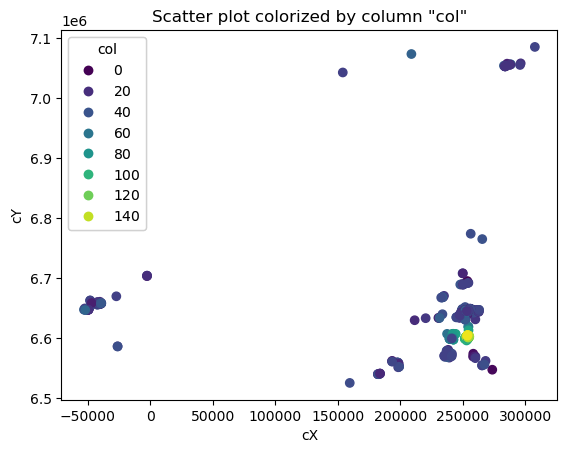

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a scatter plot
fig, ax = plt.subplots()
scatter = ax.scatter(tt['Centroid_X'], tt['Centroid_Y'], c=tt['PC_large'].astype('category').cat.codes, cmap='viridis')

# Add a legend
legend1 = ax.legend(*scatter.legend_elements(), title="col")
ax.add_artist(legend1)

# Set labels and title
ax.set_xlabel('cX')
ax.set_ylabel('cY')
ax.set_title('Scatter plot colorized by column "col"')

# Show the plot
plt.show()

In [ ]:
eigen_measures_df

### Tilfeldig landskap

# Grunnkart

In [ ]:
import arcpy

def grunnkartsammensling():
    # To allow overwriting outputs change overwriteOutput option to True.
    arcpy.env.overwriteOutput = False
    arcpy.env.parallelProcessingFactor = "90%"


    srcs = {
        'arealregnskap_18': "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\18_25833_arealregnskap_gdb.gdb\\arealregnskap_18",
        'arealregnskap_15': "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\15_25832_arealregnskap_gdb.gdb\\arealregnskap_15",
        "arealregnskap_31": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\31_25832_arealregnskap_gdb.gdb\\arealregnskap_31",
        "arealregnskap_33": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\33_25832_arealregnskap_gdb.gdb\\arealregnskap_33",
        "arealregnskap_34": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\34_25832_arealregnskap_gdb.gdb\\arealregnskap_34",
        "arealregnskap_39": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\39_25832_arealregnskap_gdb.gdb\\arealregnskap_39",
        "arealregnskap_40": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\40_25832_arealregnskap_gdb.gdb\\arealregnskap_40",
        "arealregnskap_42": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\42_25832_arealregnskap_gdb.gdb\\arealregnskap_42",
        "arealregnskap_4_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\50_25832_arealregnskap_gdb.gdb\\arealregnskap",
        "arealregnskap_6_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\55_25833_arealregnskap_gdb.gdb\\arealregnskap",
        "arealregnskap_7_": "G:\\temp\\endre\\GrunnkartArealregnskap FGDB-format\\56_25835_arealregnskap_gdb.gdb\\arealregnskap"
    }

    for name, path in srcs.items():
        print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+name)
        # Process: Select Layer By Attribute (Select Layer By Attribute) (management)
        arealregnskap, Count = arcpy.management.SelectLayerByAttribute(in_layer_or_view=path, where_clause="arealdekke <> 'Hav'")

        # Process: Pairwise Dissolve (Pairwise Dissolve) (analysis)
        dissolved_output = f"G:\\temp\\endre\\outStandard.gdb\\{name}_d"
        try:
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri slås sammen")
            arcpy.analysis.PairwiseDissolve(in_features=arealregnskap, out_feature_class=dissolved_output, multi_part="MULTI_PART")
        except arcpy.ExecuteError:
            # If Pairwise Dissolve fails, repair geometry and try again
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri må reparareres")
            Repaired_Input_Features = arcpy.management.RepairGeometry(in_features=arealregnskap)[0]
            
            print(str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))+":"+"         Geometri slås sammen")
            arcpy.analysis.PairwiseDissolve(in_features=Repaired_Input_Features, out_feature_class=dissolved_output, multi_part="MULTI_PART")

        # Process: Merge (Merge) (management)
        #merged_output = "G:\\temp\\endre\\Standard.gdb\\arealregnskap_d_Merge"
        ##arcpy.management.Merge(inputs=[dissolved_output], output=merged_output, add_source="ADD_SOURCE_INFO")

if __name__ == '__main__':
    # Global Environment settings
    with arcpy.EnvManager(scratchWorkspace="G:\\temp\\endre\\Standard.gdb", workspace="G:\\temp\\endre\\Standard.gdb"):
        grunnkartsammensling()